# Importing required Dependencies for the code to work 

In [59]:
# import dependencies

import pandas as pd
import json
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series
from scipy import stats
from folium.plugins import HeatMap

import geoplotlib
from geoplotlib.utils import read_csv 

import folium
from folium import plugins

%matplotlib inline

# Preparing Data

    Reading the CSV data file. 
    This file contains SF crime data from Jan'2011 - Feb'2018

In [60]:
# Read input files 

crime_file = "../data/_Change_Notice__Police_Department_Incidents.csv"
crime_data_All_DF = pd.read_csv(crime_file)
crime_data_All_DF = crime_data_All_DF.sort_values(["Date"], ascending=False)
crime_data_All_DF.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
2046707,171055344,FRAUD,"CREDIT CARD, THEFT BY USE OF",Sunday,12/31/2017,15:00,PARK,NONE,FULTON ST / PIERCE ST,-122.434866,37.777281,"(37.77728097494415, -122.43486585349764)",17105534409320
1892266,180002786,FORGERY/COUNTERFEITING,"FORGERY, NOTES",Sunday,12/31/2017,22:30,BAYVIEW,NONE,100 Block of COLBY ST,-122.413784,37.728286,"(37.72828621932752, -122.41378387003788)",18000278609150


In [61]:
#writing 'total crime by Date' to CSV file which can be used later

crime_df = crime_data_All_DF.groupby(['Date'])
crime_monthly_df = pd.DataFrame(crime_df['Date'].value_counts())
crime_monthly_df.to_csv("../data/Crime_2.csv")

In [62]:
# some data exploration 

len(crime_data_All_DF)

2184879

In [63]:
crime_data_All_DF.columns

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'],
      dtype='object')

In [64]:
crime_data_All_DF = crime_data_All_DF.rename(columns={"IncidntNum":"ID",
                                       "Category":"Category",
                                       "Descript":"Descript",
                                       "DayOfWeek":"Day Of Week",
                                       "Date":"Date",
                                       "Time":"Time",
                                       "PdDistrict":"District",
                                       "Resolution":"Resolution"})
crime_data_All_DF.columns

Index(['ID', 'Category', 'Descript', 'Day Of Week', 'Date', 'Time', 'District',
       'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'],
      dtype='object')

In [65]:
#keep only the required columns 
# Extract some columns
crime_data_All_DF = crime_data_All_DF.loc[:,['Category', 'Descript', 'Day Of Week', 'Date', 'Time', 'District',
       'Resolution', 'Address', 'X', 'Y']]
crime_data_All_DF.head(2)

,Category,Descript,Day Of Week,Date,Time,District,Resolution,Address,X,Y
2046707,FRAUD,"CREDIT CARD, THEFT BY USE OF",Sunday,12/31/2017,15:00,PARK,NONE,FULTON ST / PIERCE ST,-122.434866,37.777281
1892266,FORGERY/COUNTERFEITING,"FORGERY, NOTES",Sunday,12/31/2017,22:30,BAYVIEW,NONE,100 Block of COLBY ST,-122.413784,37.728286


In [66]:
crime_data_All_DF["Resolved"] = np.where(crime_data_All_DF["Resolution"]=='NONE', "Unresolved","Resolved")

#split the date column into year , month, date for easy access

# Create a new columns for Year, Day and Month
crime_data_All_DF["Year"] = crime_data_All_DF["Date"].str.rstrip('/').str.split('/').str[2]
crime_data_All_DF["Day"] = crime_data_All_DF["Date"].str.rstrip('/').str.split('/').str[1]
crime_data_All_DF["Month"] = crime_data_All_DF["Date"].str.rstrip('/').str.split('/').str[0]
crime_data_All_DF["Hour"] = crime_data_All_DF["Time"].str.rstrip(':').str.split(':').str[0].astype(int)  

crime_data_All_DF = crime_data_All_DF.sort_values(["Year"], ascending=False)

crime_data_All_DF.head(2)

,Category,Descript,Day Of Week,Date,Time,District,Resolution,Address,X,Y,Resolved,Year,Day,Month,Hour
1909288,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Sunday,01/28/2018,16:30,PARK,NONE,700 Block of CLAYTON ST,-122.448266,37.767909,Unresolved,2018,28,01,16
1893084,NON-CRIMINAL,"STAY AWAY OR COURT ORDER, NON-DV RELATED",Wednesday,01/03/2018,12:35,BAYVIEW,NONE,1100 Block of 4TH ST,-122.391470,37.773118,Unresolved,2018,03,01,12


In [67]:
bins = [0, 7, 14, 20, 23]
group_names = ['EarlyMorning', 'Morning', 'Evening', 'Night']


crime_data_All_DF["Hour_Bin"] = pd.cut(crime_data_All_DF["Hour"], bins, labels=group_names)
crime_data_All_DF.head(2)

,Category,Descript,Day Of Week,Date,Time,District,Resolution,Address,X,Y,Resolved,Year,Day,Month,Hour,Hour_Bin
1909288,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Sunday,01/28/2018,16:30,PARK,NONE,700 Block of CLAYTON ST,-122.448266,37.767909,Unresolved,2018,28,01,16,Evening
1893084,NON-CRIMINAL,"STAY AWAY OR COURT ORDER, NON-DV RELATED",Wednesday,01/03/2018,12:35,BAYVIEW,NONE,1100 Block of 4TH ST,-122.391470,37.773118,Unresolved,2018,03,01,12,Morning


In [68]:
crime_data_All_DF = crime_data_All_DF.sort_values(['Year','Month', 'Day'], ascending=[False, True,True])
crime_data_All_DF.head(2)

,Category,Descript,Day Of Week,Date,Time,District,Resolution,Address,X,Y,Resolved,Year,Day,Month,Hour,Hour_Bin
1891996,WARRANTS,ENROUTE TO DEPARTMENT OF CORRECTIONS,Monday,01/01/2018,14:07,MISSION,"ARREST, BOOKED",1400 Block of HAMPSHIRE ST,-122.406622,37.749348,Resolved,2018,01,01,14,Morning
1892001,OTHER OFFENSES,RESISTING ARREST,Monday,01/01/2018,14:50,CENTRAL,"ARREST, BOOKED",1000 Block of FRONT ST,-122.400322,37.801310,Resolved,2018,01,01,14,Morning


In [69]:
crime_data_All_DF["Year"].value_counts()

2015    156526
2017    154245
2013    152806
2016    150883
2014    150128
2003    149176
2004    148148
2005    142186
2008    141311
2012    140847
2009    139860
2006    137853
2007    137639
2010    133523
2011    132697
2018     17051
Name: Year, dtype: int64

In [70]:
# slice the data for 2016,2017,2018 so that we can start plotting

crime_data_2003_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2003",:]
crime_data_2004_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2004",:]
crime_data_2005_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2005",:]
crime_data_2006_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2006",:]
crime_data_2007_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2007",:]
crime_data_2008_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2008",:]
crime_data_2009_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2009",:]
crime_data_2010_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2010",:]
crime_data_2011_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2011",:]
crime_data_2012_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2012",:]
crime_data_2013_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2013",:]
crime_data_2014_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2014",:]
crime_data_2015_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2015",:]
crime_data_2016_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2016",:]
crime_data_2017_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2017",:]
crime_data_2018_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == "2018",:]




# Heatmap - Crimes by Category & District : 2016

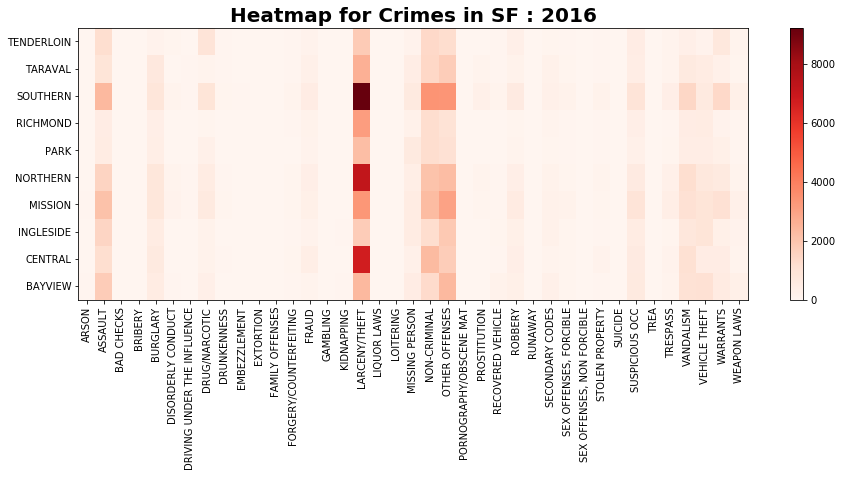

In [71]:
#2016 Heatmap for crimes 

#Cross-tabulate Category and PdDistrict
crime_data_2016_CT = pd.crosstab(crime_data_2016_DF.District,crime_data_2016_DF.Category,margins=True)
#delete the column 'All' 
del crime_data_2016_CT['All'] 
# delete the last row 'All'
crime_data_2016_CT = crime_data_2016_CT.iloc[:-1] 

#set the labels
column_labels_2016 = list(crime_data_2016_CT.columns.values)
row_labels_2016 = crime_data_2016_CT.index.values.tolist()

#plot to a heatmap using matplotlib  
fig,ax = plt.subplots()
heatmap = ax.pcolor(crime_data_2016_CT,cmap='Reds')

#format
 
fig.set_size_inches(15,5)
 

# Tick placement 

ax.set_yticks(np.arange(crime_data_2016_CT.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(crime_data_2016_CT.shape[1])+0.5, minor=False)

 
ax.set_xticklabels(column_labels_2016, minor=False)
ax.set_yticklabels(row_labels_2016, minor=False)
#rotate
plt.xticks(rotation=90)
plt.title("Heatmap for Crimes in SF : 2016", fontsize=20, weight='bold')
plt.colorbar(heatmap)
plt.savefig ("../plot/Heat_map_2016.png")
plt.show()



# Heatmap - Crimes by Category & District : 2017

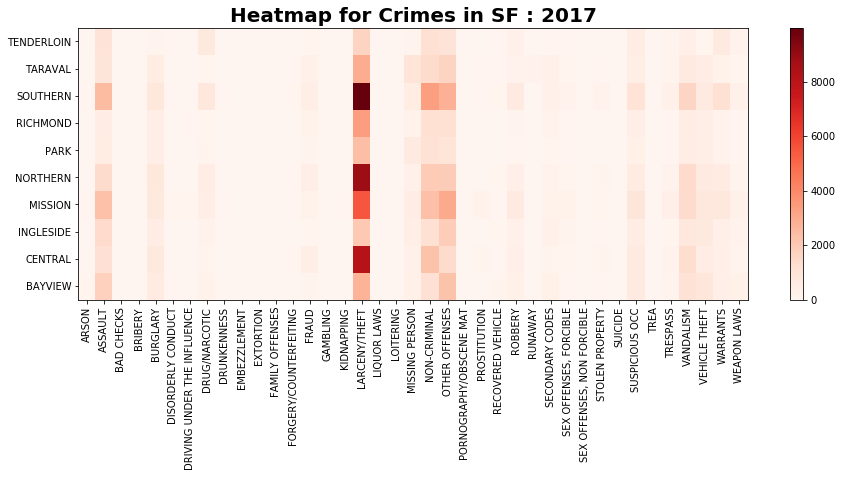

In [72]:
# # 2017 Heatmap

# In[25]:


#Cross-tabulate Category and PdDistrict
crime_data_2017_CT = pd.crosstab(crime_data_2017_DF.District,crime_data_2017_DF.Category,margins=True)
del crime_data_2017_CT['All'] #delete the All column
crime_data_2017_CT = crime_data_2017_CT.iloc[:-1]# delete last row (All)

#set the labels
column_labels_2017 = list(crime_data_2017_CT.columns.values)
row_labels_2017 = crime_data_2017_CT.index.values.tolist()

#plot to a heatmap using matplotlib  
fig,ax = plt.subplots()
heatmap = ax.pcolor(crime_data_2017_CT,cmap='Reds')

#format
 
fig.set_size_inches(15,5)
 

# Tick placement 

ax.set_yticks(np.arange(crime_data_2017_CT.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(crime_data_2017_CT.shape[1])+0.5, minor=False)

 
ax.set_xticklabels(column_labels_2017, minor=False)
ax.set_yticklabels(row_labels_2017, minor=False)
#rotate
plt.xticks(rotation=90)
plt.title("Heatmap for Crimes in SF : 2017", fontsize=20, weight='bold')
plt.colorbar(heatmap)
plt.savefig ("../plot/Heat_map_2017.png")
plt.show()

# Heatmap - Crimes by Category & District : 2018

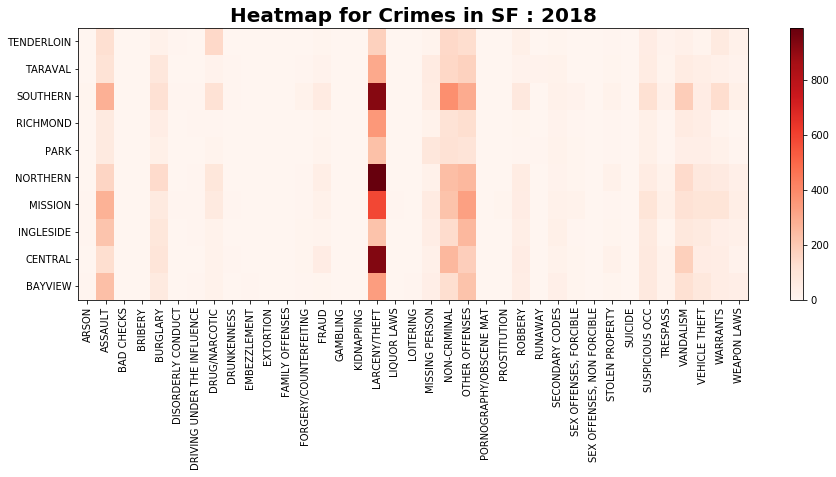

In [73]:
# # 2018 Heatmap

# In[24]:


#Cross-tabulate Category and PdDistrict
crime_data_2018_CT = pd.crosstab(crime_data_2018_DF.District,crime_data_2018_DF.Category,margins=True)
del crime_data_2018_CT['All'] #delete the All column
crime_data_2018_CT = crime_data_2018_CT.iloc[:-1]# delete last row (All)

#set the labels
column_labels_2018 = list(crime_data_2018_CT.columns.values)
row_labels_2018 = crime_data_2018_CT.index.values.tolist()

#plot to a heatmap using matplotlib  
fig,ax = plt.subplots()
heatmap = ax.pcolor(crime_data_2018_CT,cmap='Reds')

#format
 
fig.set_size_inches(15,5)
 

# Tick placement 

ax.set_yticks(np.arange(crime_data_2018_CT.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(crime_data_2018_CT.shape[1])+0.5, minor=False)

 
ax.set_xticklabels(column_labels_2018, minor=False)
ax.set_yticklabels(row_labels_2018, minor=False)
#rotate
plt.xticks(rotation=90)
plt.title("Heatmap for Crimes in SF : 2018", fontsize=20, weight='bold')
plt.colorbar(heatmap)
plt.savefig ("../plot/Heat_map_2018.png")
plt.show()



# Bar Graph : Crimes by Category  - 2016

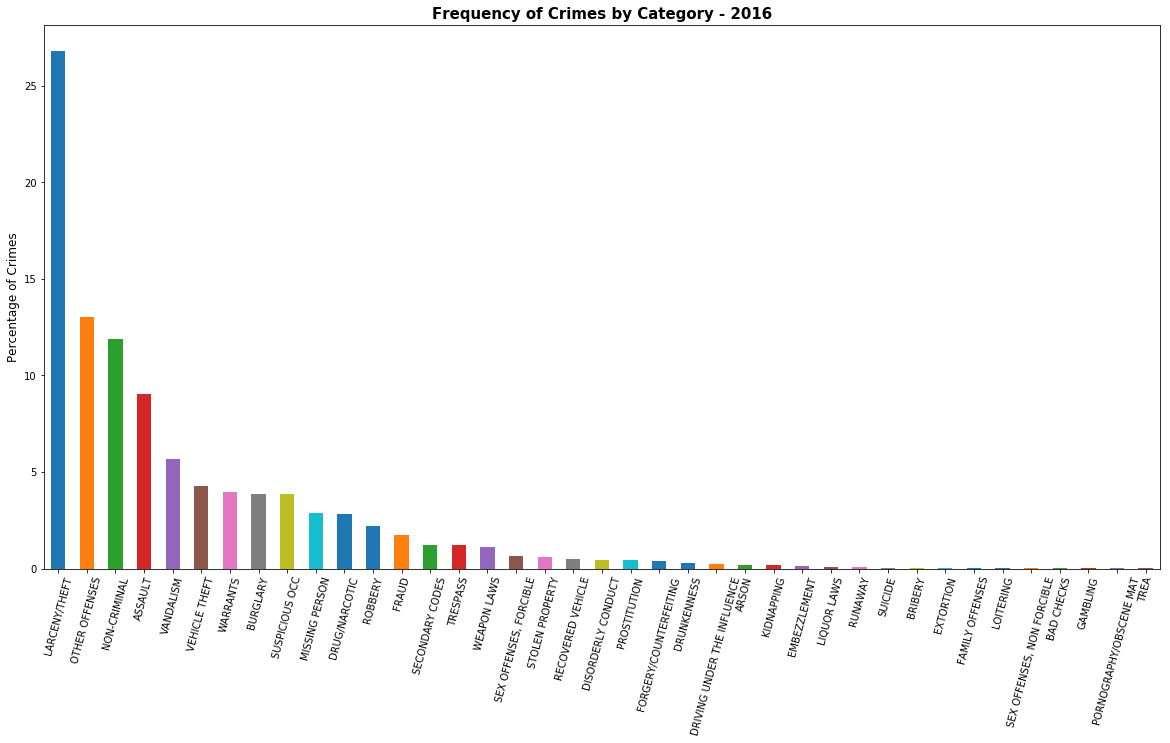

In [74]:
#frequency count for Category
Category_crimes_2016_df = pd.DataFrame(crime_data_2016_DF.Category.value_counts())


Category_crimes_2016_df["Percentage"] = (Category_crimes_2016_df["Category"]/Category_crimes_2016_df["Category"].sum())*100
Category_crimes_2016_df
 
fig = Category_crimes_2016_df["Percentage"].plot(kind="bar", figsize = (20,10), rot=75) 

fig.set_title("Frequency of Crimes by Category - 2016", fontsize=15, weight = "bold")
fig.set_ylabel("Percentage of Crimes", fontsize=12)
plt.savefig('../plot/perc_crime_category_2016.png')
plt.show()

# Bar Graph : Average crime for each day of the week - 2016

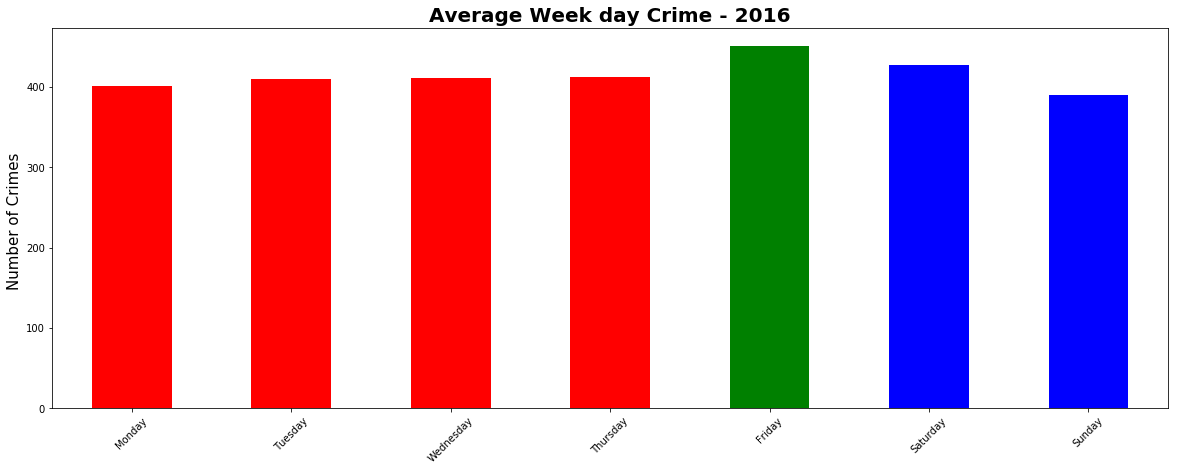

In [75]:
#Average daily crime per category
avg_daily_crime = pd.DataFrame(crime_data_2016_DF["Day Of Week"].value_counts()/52)

avg_daily_crime.columns=['avg']
avg_daily_crime.reset_index(inplace=True)
avg_daily_crime.rename(columns = {"index": "day"},   inplace=True)
avg_daily_crime

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = avg_daily_crime['day'].map(mapping)
avg_daily_crime = avg_daily_crime.iloc[key.argsort()]

ax= avg_daily_crime.plot(x='day', kind="bar", figsize = (20,7), width = 0.5, rot=45, color= "rrrrgbb", legend=False)
ax.set_xlabel('')

ax.set_title("Average Week day Crime - 2016", fontsize=20, weight='bold')
ax.set_ylabel("Number of Crimes ", fontsize= 15)
plt.savefig('../plot/avg_daily2016.png')
plt.show()

# Bar Graph : Crimes by Category - 2017

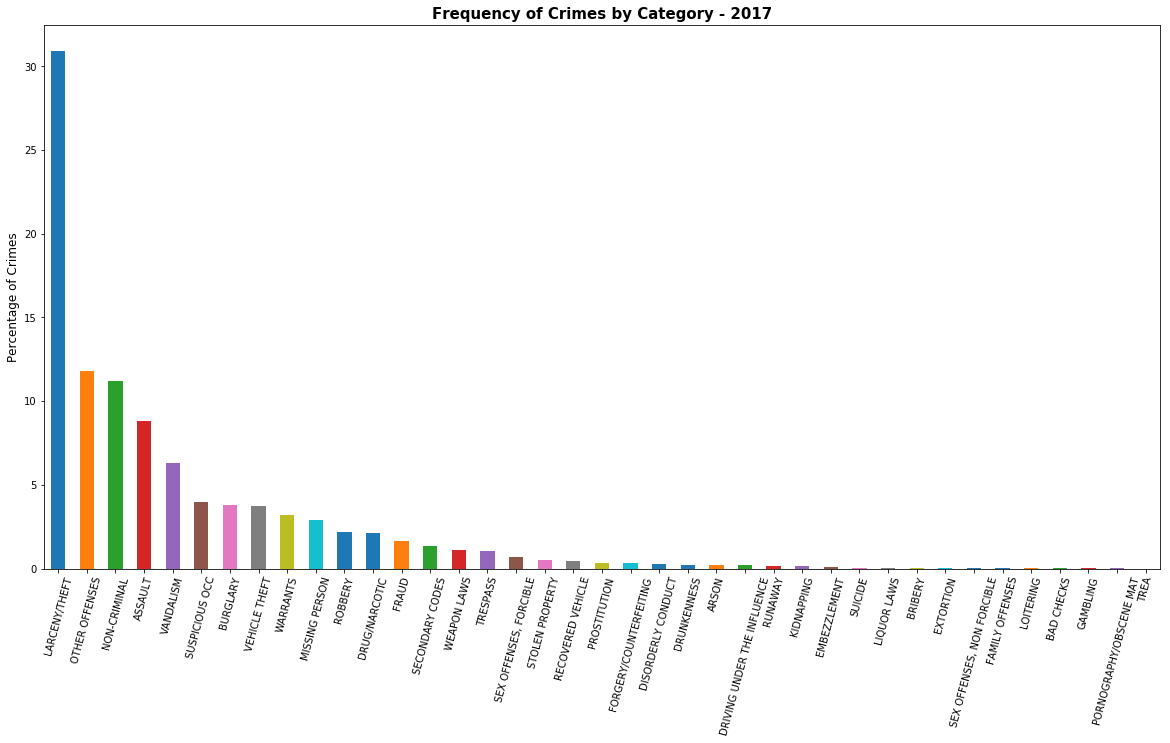

In [76]:
# Percentage of crime per category
Category_crimes_2017_df = pd.DataFrame(crime_data_2017_DF.Category.value_counts())


Category_crimes_2017_df["Percentage"] = (Category_crimes_2017_df["Category"]/Category_crimes_2017_df["Category"].sum())*100
 
fig = Category_crimes_2017_df["Percentage"].plot(kind="bar", figsize = (20,10), rot=75) 

fig.set_title("Frequency of Crimes by Category - 2017", fontsize=15, weight = "bold")
fig.set_ylabel("Percentage of Crimes", fontsize=12)
plt.savefig('../plot/perc_crime_category_2017.png')
plt.show()



# Bar Graph : Average crime for each day of the week - 2017

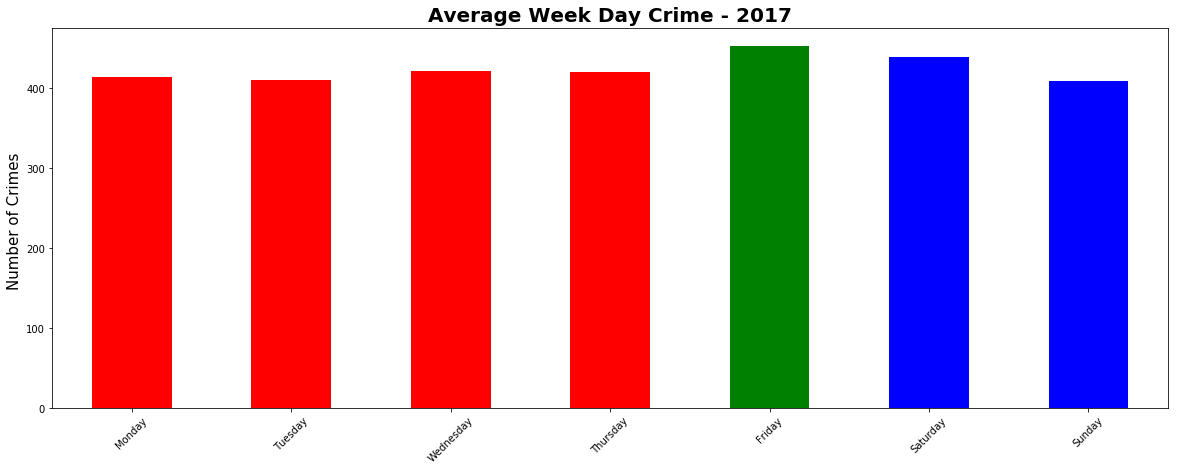

In [77]:
# Average daily crime per category
avg_daily_crime = pd.DataFrame(crime_data_2017_DF["Day Of Week"].value_counts()/52)

avg_daily_crime.columns=['avg']
avg_daily_crime.reset_index(inplace=True)
avg_daily_crime.rename(columns = {"index": "day"},   inplace=True)
avg_daily_crime

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = avg_daily_crime['day'].map(mapping)
avg_daily_crime = avg_daily_crime.iloc[key.argsort()]

ax= avg_daily_crime.plot(x='day', kind="bar", figsize = (20,7), width = 0.5, rot=45, color= "rrrrgbb", legend=False)
ax.set_xlabel('')

ax.set_title("Average Week Day Crime - 2017", fontsize=20, weight='bold')
ax.set_ylabel("Number of Crimes ", fontsize= 15)
plt.savefig('../plot/avg_daily2017.png')
plt.show()

# Bar Graph : Crimes by Category - 2018

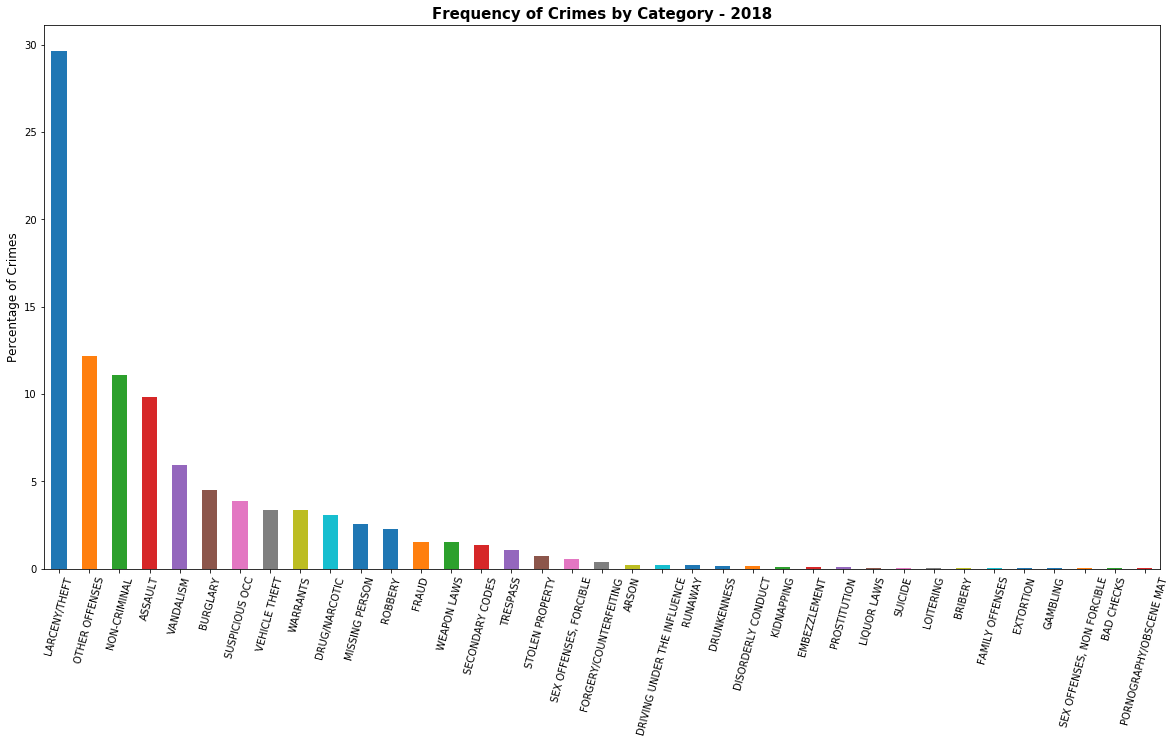

In [105]:
# Percentage of crime per category

Category_crimes_2018_df = pd.DataFrame(crime_data_2018_DF.Category.value_counts())


Category_crimes_2018_df["Percentage"] = (Category_crimes_2018_df["Category"]/Category_crimes_2018_df["Category"].sum())*100
 
fig = Category_crimes_2018_df["Percentage"].plot(kind="bar", figsize = (20,10), rot=75) 

fig.set_title("Frequency of Crimes by Category - 2018", fontsize=15, weight = "bold")
fig.set_ylabel("Percentage of Crimes", fontsize=12)
plt.savefig('../plot/perc_crime_category_2018.png')
plt.show()



# Bar Graph : Average crime for each day of the week - 2018

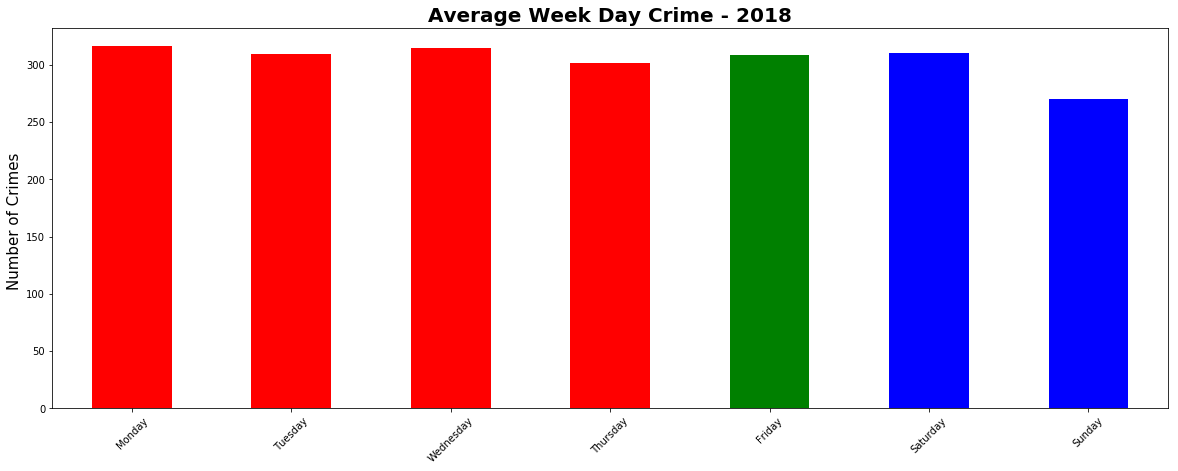

In [79]:
# Average daily crime per category

avg_daily_crime = pd.DataFrame(crime_data_2018_DF["Day Of Week"].value_counts()/8)

avg_daily_crime.columns=['avg']
avg_daily_crime.reset_index(inplace=True)
avg_daily_crime.rename(columns = {"index": "day"},   inplace=True)
avg_daily_crime

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = avg_daily_crime['day'].map(mapping)
avg_daily_crime = avg_daily_crime.iloc[key.argsort()]

ax= avg_daily_crime.plot(x='day', kind="bar", figsize = (20,7), width = 0.5, rot=45, color= "rrrrgbb", legend=False)
ax.set_xlabel('')

ax.set_title("Average Week Day Crime - 2018", fontsize=20, weight='bold')
ax.set_ylabel("Number of Crimes ", fontsize= 15)
plt.savefig('../plot/avg_daily2018.png')
plt.show()

# Heatmap - Crimes by District & Hour of the day : 2016

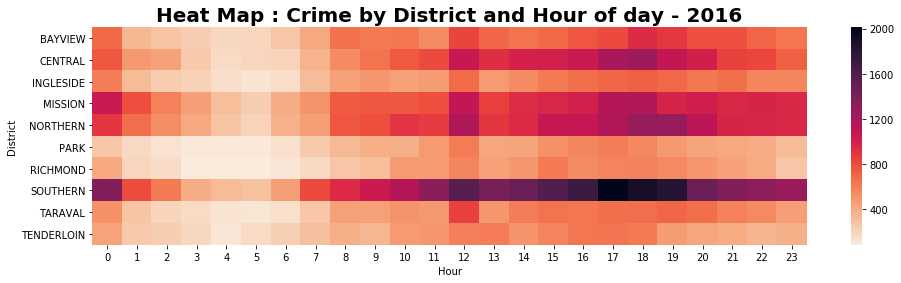

In [80]:
# # Heatmap:  crime by District and time 2016



df_gb = pd.DataFrame(crime_data_2016_DF.groupby(['District', 'Hour']).size())
df_gb.reset_index(inplace=True)
df_gb.rename(columns={0:"Crimes"}, inplace=True)
df_h = df_gb.pivot("District", "Hour", "Crimes")
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
ax = sns.heatmap(df_h, ax=ax, cmap= sns.cm.rocket_r )
plt.title('Heat Map : Crime by District and Hour of day - 2016', fontsize=20, weight='bold')
plt.savefig ("../plot/heatmap_time_2016.png")
plt.show()

# Heatmap - Crimes by District & Hour of the day : 2017

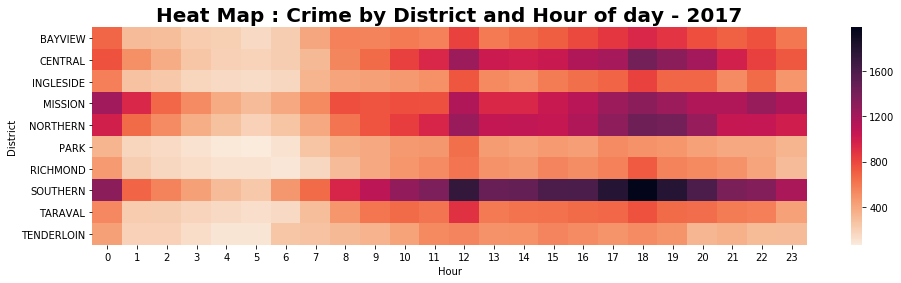

In [81]:
df_gb2 = pd.DataFrame(crime_data_2017_DF.groupby(['District', 'Hour']).size())
df_gb2.reset_index(inplace=True)
df_gb2.rename(columns={0:"Crimes"}, inplace=True)
df_h2 = df_gb2.pivot("District", "Hour", "Crimes")
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
ax = sns.heatmap(df_h2, ax=ax, cmap= sns.cm.rocket_r)
plt.title('Heat Map : Crime by District and Hour of day - 2017', fontsize=20, weight='bold')
plt.savefig ("../plot/heatmap_time_2017.png")
plt.show()

# Heatmap - Crimes by District & Hour of the day : 2018

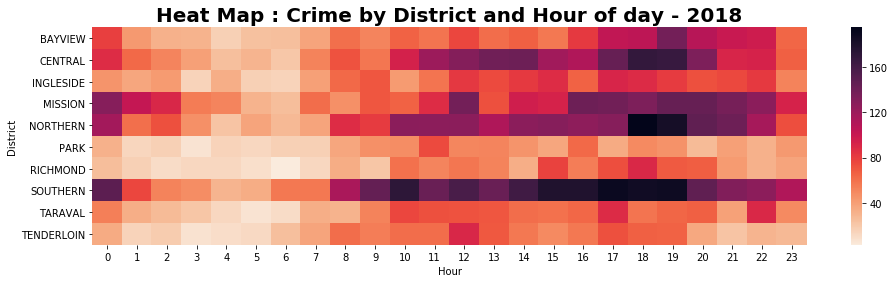

In [82]:
df_gb3 = pd.DataFrame(crime_data_2018_DF.groupby(['District', 'Hour']).size())
df_gb3.reset_index(inplace=True)
df_gb3.rename(columns={0:"Crimes"}, inplace=True)
df_h3 = df_gb3.pivot("District", "Hour", "Crimes")
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
ax = sns.heatmap(df_h3, ax=ax, cmap= sns.cm.rocket_r)
plt.savefig ("../plot/heatmap_time_2018.png")
plt.title('Heat Map : Crime by District and Hour of day - 2018', fontsize=20, weight='bold')
plt.show()

# Bubble plot - Unresolved Crimes by District over the Years

In [83]:
##Getting 2016 unresolved crimes in series
district_2016 = crime_data_2016_DF.groupby(by = ['District',"Resolved"])
district_2016= district_2016.count()
district_2016 = district_2016.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2016_df=pd.DataFrame(district_2016)
district_2016_df = district_2016_df.rename(columns={"Category":"Count"})
district_2016_df = district_2016_df.reset_index()
unresolved_2016 = district_2016_df.loc[district_2016_df["Resolved"] =="Unresolved","Count"]
district_2016 = district_2016_df["District"].unique()

##Getting 2017 unresolved crimes in series
district_2017 = crime_data_2017_DF.groupby(by = ['District',"Resolved"])
district_2017= district_2017.count()
district_2017 = district_2017.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2017_df=pd.DataFrame(district_2017)
district_2017_df = district_2017_df.rename(columns={"Category":"Count"})
district_2017_df = district_2017_df.reset_index()
unresolved_2017 = district_2017_df.loc[district_2017_df["Resolved"] =="Unresolved","Count"]
district_2017 = district_2017_df["District"].unique()

##Getting 2015 unresolved crimes in series
district_2015 = crime_data_2015_DF.groupby(by = ['District',"Resolved"])
district_2015= district_2015.count()
district_2015 = district_2015.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2015_df=pd.DataFrame(district_2015)
district_2015_df = district_2015_df.rename(columns={"Category":"Count"})
district_2015_df = district_2015_df.reset_index()
unresolved_2015 = district_2015_df.loc[district_2015_df["Resolved"] =="Unresolved","Count"]
district_2015 = district_2015_df["District"].unique()

##Getting 2014 unresolved crimes in series
district_2014 = crime_data_2014_DF.groupby(by = ['District',"Resolved"])
district_2014= district_2014.count()
district_2014 = district_2014.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2014_df=pd.DataFrame(district_2014)
district_2014_df = district_2014_df.rename(columns={"Category":"Count"})
district_2014_df = district_2014_df.reset_index()
unresolved_2014 = district_2014_df.loc[district_2014_df["Resolved"] =="Unresolved","Count"]
district_2014 = district_2014_df["District"].unique()

##Getting 2011 unresolved crimes in series
district_2011 = crime_data_2011_DF.groupby(by = ['District',"Resolved"])
district_2011= district_2011.count()
district_2011 = district_2011.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2011_df=pd.DataFrame(district_2011)
district_2011_df = district_2011_df.rename(columns={"Category":"Count"})
district_2011_df = district_2011_df.reset_index()
unresolved_2011 = district_2011_df.loc[district_2014_df["Resolved"] =="Unresolved","Count"]
district_2011 = district_2011_df["District"].unique()

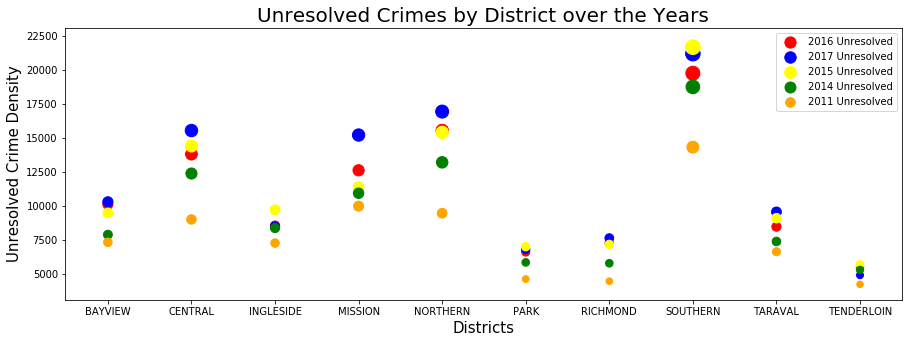

In [106]:
## building the plot

plt.figure(figsize=(15,5))
## plotting 2016 Data
data1 = plt.scatter(district_2016,unresolved_2016,
                    marker= 'o',color='red',label ='2016 Unresolved',s=(unresolved_2016/100))
data2 = plt.scatter(district_2017,unresolved_2017,marker='o',color='blue',label ='2017 Unresolved',s=(unresolved_2017/100))

## plotting 2017 Data
data3 = plt.scatter(district_2015,unresolved_2015,
                    marker= 'o',color='yellow',label ='2015 Unresolved',s=(unresolved_2015/100))
data4 = plt.scatter(district_2014,unresolved_2014,marker='o',color='green',label ='2014 Unresolved',s=(unresolved_2014/100))

data5 = plt.scatter(district_2011,unresolved_2011,marker='o',color='orange',label ='2011 Unresolved',s=(unresolved_2011/100))

plt.legend(handles=[data1,data2,data3,data4,data5],loc="best")
plt.title("Unresolved Crimes by District over the Years",fontsize = 20)
plt.xlabel("Districts",fontsize=15)
plt.ylabel("Unresolved Crime Density",fontsize=15)
plt.savefig("../plot/Unresolved Crimes.jpg")
plt.show()



In [85]:
# Select 2011, 2015, 2016, 2017 and 2018
Years = ["2011", "2015", "2016", "2017", "2018"]
reduced_crime_data_df = crime_data_All_DF[crime_data_All_DF['Year'].isin(Years)]
reduced_crime_data_df.head()

,Category,Descript,Day Of Week,Date,Time,District,Resolution,Address,X,Y,Resolved,Year,Day,Month,Hour,Hour_Bin
1891996,WARRANTS,ENROUTE TO DEPARTMENT OF CORRECTIONS,Monday,01/01/2018,14:07,MISSION,"ARREST, BOOKED",1400 Block of HAMPSHIRE ST,-122.406622,37.749348,Resolved,2018,01,01,14,Morning
1892001,OTHER OFFENSES,RESISTING ARREST,Monday,01/01/2018,14:50,CENTRAL,"ARREST, BOOKED",1000 Block of FRONT ST,-122.400322,37.801310,Resolved,2018,01,01,14,Morning
1894365,OTHER OFFENSES,RESTRAINING ORDER NOTIFICATION/SERVICE OF REST...,Monday,01/01/2018,19:00,MISSION,"ARREST, BOOKED",500 Block of GUERRERO ST,-122.423762,37.762359,Resolved,2018,01,01,19,Evening
1891823,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Monday,01/01/2018,03:00,SOUTHERN,NONE,MISSION ST / 8TH ST,-122.413161,37.777457,Unresolved,2018,01,01,3,EarlyMorning
1891821,ASSAULT,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,Monday,01/01/2018,09:00,TARAVAL,NONE,100 Block of MAJESTIC AV,-122.452481,37.716179,Unresolved,2018,01,01,9,Morning


# Line Graph - Monthly Crime trend for the years - 2011, 2016,2016,2017

In [86]:
crime_df = reduced_crime_data_df.groupby(['Year','Month'])
crime_monthly_df = pd.DataFrame(crime_df["Month"].value_counts())
crime_monthly = crime_monthly_df.unstack(0)
crime_monthly_2 = crime_monthly["Month"]

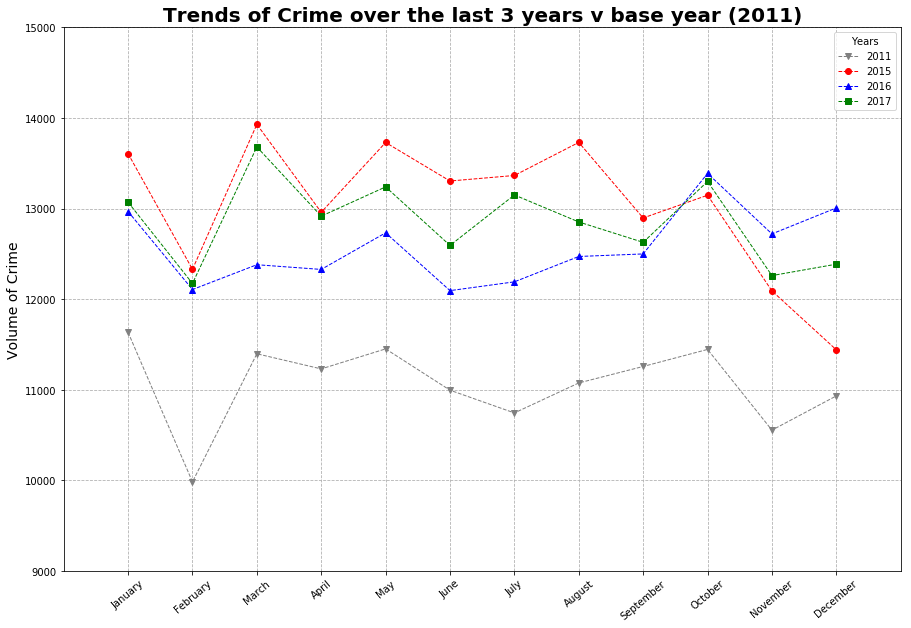

In [87]:
#Creating the line chart

#define x-axis
x_axis = [1,2,3,4,5,6,7,8,9,10,11,12]
x_limit = 13
plt.figure(figsize=(15,10))

#Define each year

year_2011 = plt.plot(x_axis, crime_monthly_2["2011"], marker="v", color="gray", ls="dashed", linewidth=1, alpha=1)

year_2015 = plt.plot(x_axis, crime_monthly_2["2015"], marker="o", color="red", ls="dashed", linewidth=1, alpha=1)

year_2016 = plt.plot(x_axis, crime_monthly_2["2016"], marker="^", color="blue", ls="dashed", linewidth=1, alpha=1)

year_2017 = plt.plot(x_axis, crime_monthly_2["2017"], marker="s", color="green", ls="dashed", linewidth=1, alpha=1)


#Axes limits
plt.ylim(9000, 15000)
plt.xlim(0, 13)

#Axes and Chart Labels
plt.title("Trends of Crime over the last 3 years v base year (2011)", fontsize=20, weight='bold')
plt.ylabel("Volume of Crime", fontsize=14)
plt.xticks(1+np.arange(12), calendar.month_name[1:13], rotation=40)
plt.grid(linestyle="dashed")

# Save the figure
plt.savefig('../plot/Trends of Crime over the last 3 years.png')

#Chart Legend 
plt.legend(bbox_to_anchor = (1,1), title = 'Years') 
plt.show()



# Monthly Crime trend for the years - 2011, 2016,2016,2017

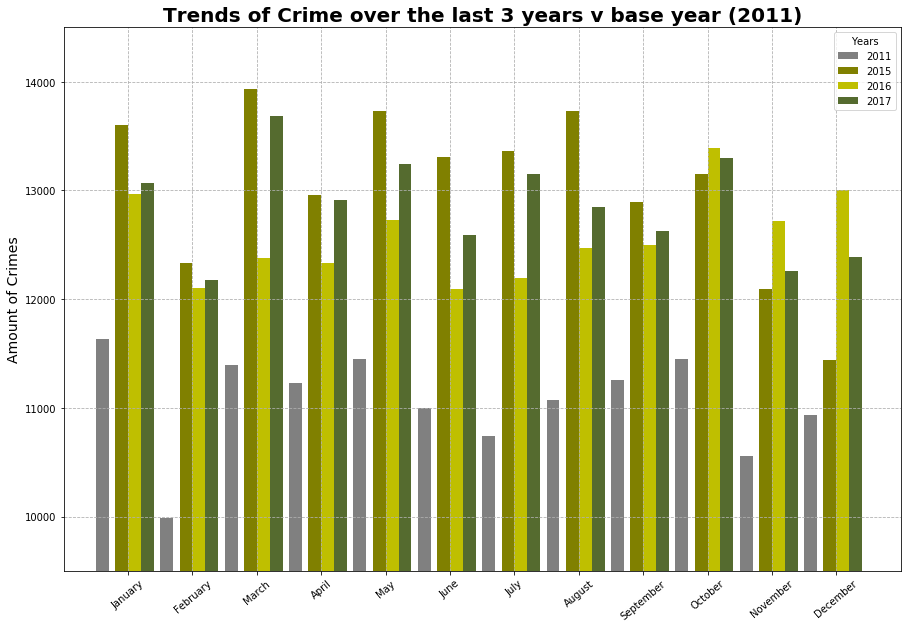

In [88]:
#Creating bar chart

#define x-axis
x_axis = 0.50+np.arange(12)
x_limit = 13
plt.figure(figsize=(15,10))
bar_width = 0.20

#Define each year

year_2011 = plt.bar(x_axis+ bar_width/2, crime_monthly_2["2011"], bar_width, color="gray", label= "2011")

year_2015 = plt.bar(x_axis + 2*bar_width, crime_monthly_2["2015"], bar_width, color="olive", label= "2015")

year_2016 = plt.bar(x_axis + 3*bar_width, crime_monthly_2["2016"], bar_width, color="y", label= "2016")

year_2017 = plt.bar(x_axis + 4*bar_width, crime_monthly_2["2017"], bar_width, color="darkolivegreen", label= "2017")


#Axes limits
plt.ylim(9500, 14500)
plt.xlim(0, 13)

#Axes and Chart Labels
plt.title("Trends of Crime over the last 3 years v base year (2011)", fontsize=20, weight='bold')
plt.ylabel("Amount of Crimes", fontsize=14)
plt.xticks(1+np.arange(12), calendar.month_name[1:13], rotation=40)
plt.grid(linestyle="dashed")

# Save the figure
plt.savefig('../plot/Trends of Crime over the last 3 years_2.png')

#Chart Legend 
plt.legend(bbox_to_anchor = (1,1), title = 'Years') 
plt.show()

# Seasonal Plots

/Users/Hadoop/anaconda3/envs/PythonData1/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


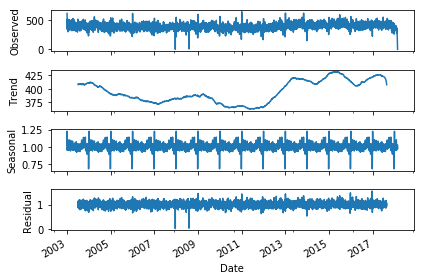

In [89]:
series = Series.from_csv('../data/Crime_3.csv', header=0)
result = seasonal_decompose(series, model='multiplicative', freq= 365)
result.plot()
plt.show()


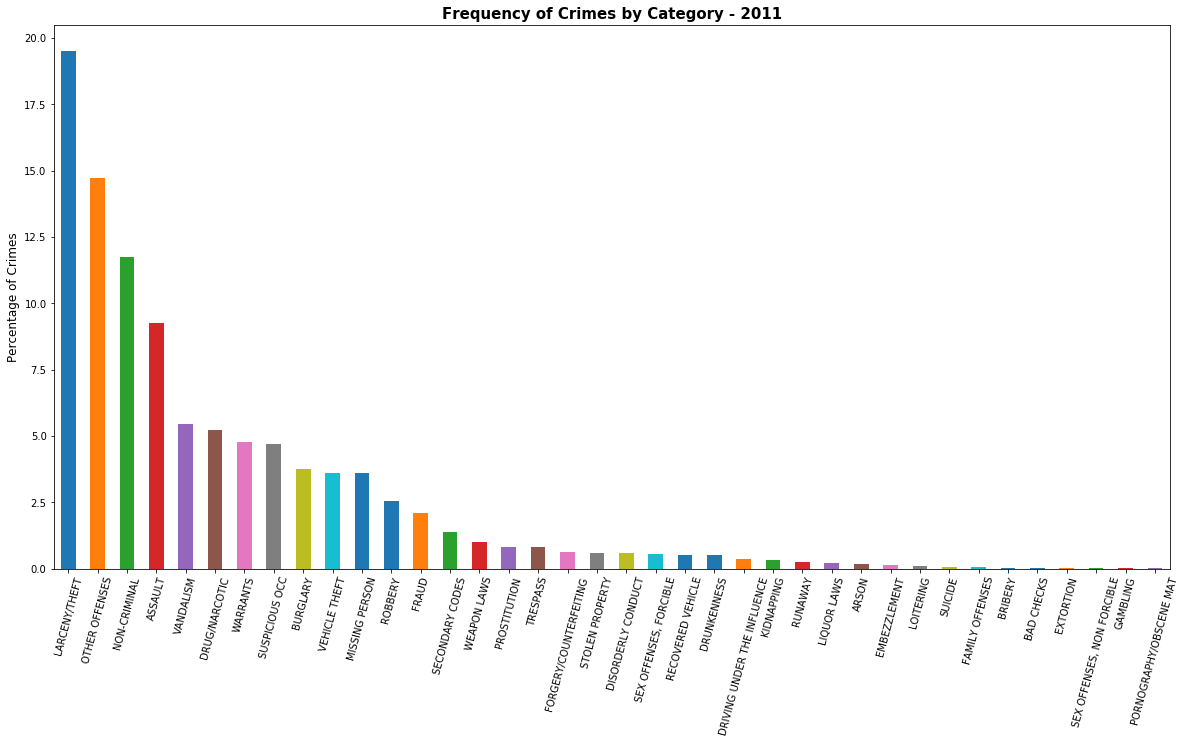

In [107]:
#frequency count for Category
Category_crimes_2011_df = pd.DataFrame(crime_data_2011_DF.Category.value_counts())


Category_crimes_2011_df["Percentage"] = (Category_crimes_2011_df["Category"]/Category_crimes_2011_df["Category"].sum())*100
Category_crimes_2011_df
 
fig = Category_crimes_2011_df["Percentage"].plot(kind="bar", figsize = (20,10), rot=75) 

fig.set_title("Frequency of Crimes by Category - 2011", fontsize=15, weight = "bold")
fig.set_ylabel("Percentage of Crimes", fontsize=12)
plt.savefig('../plot/perc_crime_category_2011.png')
plt.show()



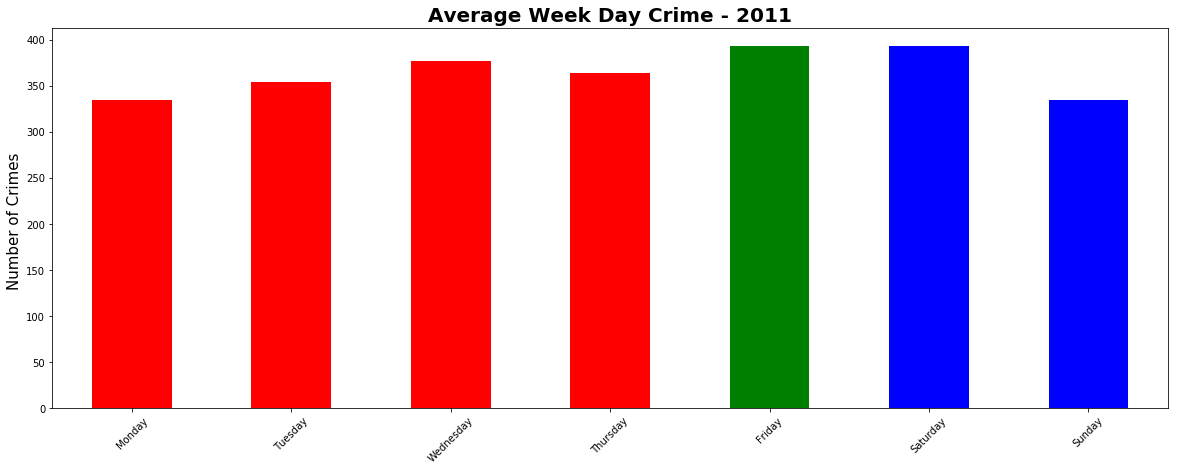

In [91]:

#Average daily crime per category
avg_daily_crime = pd.DataFrame(crime_data_2011_DF["Day Of Week"].value_counts()/52)

avg_daily_crime.columns=['avg']
avg_daily_crime.reset_index(inplace=True)
avg_daily_crime.rename(columns = {"index": "day"},   inplace=True)
avg_daily_crime

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = avg_daily_crime['day'].map(mapping)
avg_daily_crime = avg_daily_crime.iloc[key.argsort()]

ax= avg_daily_crime.plot(x='day', kind="bar", figsize = (20,7), width = 0.5, rot=45, color= 'rrrrgbb', legend=False)
ax.set_xlabel('')

ax.set_title("Average Week Day Crime - 2011", fontsize=20, weight='bold')
ax.set_ylabel("Number of Crimes ", fontsize= 15)
plt.savefig('../plot/avg_daily2011.png')
plt.show()

In [92]:
avg_daily_crime_2011_summary = crime_data_2011_DF["Day Of Week"].value_counts()/52
avg_daily_crime_2011_summary

Friday       393.480769
Saturday     393.269231
Wednesday    377.038462
Thursday     363.750000
Tuesday      354.519231
Sunday       335.076923
Monday       334.730769
Name: Day Of Week, dtype: float64

In [93]:
avg_daily_crime_2017_summary = crime_data_2017_DF["Day Of Week"].value_counts()/52
avg_daily_crime_2017_summary

Friday       452.826923
Saturday     438.750000
Wednesday    421.250000
Thursday     420.019231
Monday       413.519231
Tuesday      410.865385
Sunday       409.019231
Name: Day Of Week, dtype: float64

In [94]:
avg_daily_crime_2016_summary = crime_data_2016_DF["Day Of Week"].value_counts()/52
avg_daily_crime_2016_summary

Friday       450.788462
Saturday     427.326923
Thursday     412.673077
Wednesday    411.038462
Tuesday      409.500000
Monday       400.769231
Sunday       389.500000
Name: Day Of Week, dtype: float64

In [95]:
avg_daily_crime_2011 = avg_daily_crime_2011_summary
stats.ttest_1samp(avg_daily_crime_2011, 363.554)

Ttest_1sampResult(statistic=0.1066849788927215, pvalue=0.9185165931657153)

In [96]:
avg_daily_crime_2017 = avg_daily_crime_2017_summary
stats.ttest_1samp(avg_daily_crime_2017, 422.463)

Ttest_1sampResult(statistic=0.20994548601674748, pvalue=0.8406577737413943)

In [97]:
avg_daily_crime_2016 = avg_daily_crime_2016_summary
stats.ttest_1samp(avg_daily_crime_2016, 412.249)

Ttest_1sampResult(statistic=0.30372251276763623, pvalue=0.7715961908855425)

# Geo-Plot : All crimes - 2017

In [98]:
data = crime_data_2017_DF.loc[crime_data_2017_DF['Resolved'] == 'Resolved',['Category','X','Y']]

data = data.rename(columns={"Category":"name",
                            "X":"lon",
                            "Y":"lat"})

data.to_csv("../data/GraphData_2017.csv", encoding="utf-8", index=False)
data.head()
data = read_csv('../data/GraphData_2017.csv')

In [99]:
geoplotlib.dot(data)
geoplotlib.savefig('../plot/AllCrimes_2017')
#geoplotlib.show()


# Map plot for Unresolved Arson : 2017 vs. 2016 (using Folium)

In [100]:
crime_data_2016_unresolvedArson_DF = crime_data_2016_DF.loc[
    (crime_data_2016_DF['Resolved'] == 'Unresolved') & 
    (crime_data_2016_DF['Category'] == 'ARSON'), :]



crime_data_2017_unresolvedArson_DF = crime_data_2017_DF.loc[
    (crime_data_2017_DF['Resolved'] == 'Unresolved') & 
    (crime_data_2017_DF['Category'] == 'ARSON'), :]



middle_lat = crime_data_2016_unresolvedArson_DF['Y'].median()
middle_lon = crime_data_2016_unresolvedArson_DF['X'].median()

In [101]:
m = folium.Map([middle_lat, middle_lon], zoom_start=12)

for _, row in crime_data_2017_unresolvedArson_DF.iterrows():
        folium.CircleMarker([row['Y'], row['X']],
                                radius=1,
                                popup=row['Address'],
                                fill_color='#3db7e4' #"#3db7e4", # divvy color
                               ).add_to(m)



for _, row in crime_data_2016_unresolvedArson_DF.iterrows():
        folium.RegularPolygonMarker([row['Y'], row['X']],
                                radius=1,
                                popup=row['Address'],
                                fill_color='#132b5e', # divvy color
                                number_of_sides=4,
                               ).add_to(m)
        
m.save('../plot/Map_Plot_Unresolved_Arson_2016_2017.html')

m



# Map plot for Unresolved Vehile Theft : 2018 (using Folium)

In [102]:
crime_data_2018_unresolvedVTheft_DF = crime_data_2018_DF.loc[
    (crime_data_2018_DF['Resolved'] == 'Unresolved') & 
    (crime_data_2018_DF['Category'] == 'VEHICLE THEFT'), :]

middle_lat = crime_data_2018_unresolvedVTheft_DF['Y'].median()
middle_lon = crime_data_2018_unresolvedVTheft_DF['X'].median()

crime_data_2018_unresolvedVTheft_DF.head()

,Category,Descript,Day Of Week,Date,Time,District,Resolution,Address,X,Y,Resolved,Year,Day,Month,Hour,Hour_Bin
1892439,VEHICLE THEFT,STOLEN TRUCK,Monday,01/01/2018,22:00,MISSION,NONE,3100 Block of 19TH ST,-122.413224,37.760652,Unresolved,2018,01,01,22,Night
1892418,VEHICLE THEFT,STOLEN AUTOMOBILE,Monday,01/01/2018,20:00,BAYVIEW,NONE,100 Block of DAKOTA ST,-122.395513,37.753618,Unresolved,2018,01,01,20,Evening
2070634,VEHICLE THEFT,STOLEN AUTOMOBILE,Monday,01/01/2018,18:00,NORTHERN,NONE,700 Block of FELL ST,-122.430194,37.774951,Unresolved,2018,01,01,18,Evening
2070636,VEHICLE THEFT,STOLEN TRUCK,Monday,01/01/2018,12:00,TARAVAL,NONE,2400 Block of 35TH AV,-122.492839,37.741341,Unresolved,2018,01,01,12,Morning
1893941,VEHICLE THEFT,STOLEN AUTOMOBILE,Monday,01/01/2018,18:00,MISSION,NONE,3400 Block of 16TH ST,-122.430495,37.764342,Unresolved,2018,01,01,18,Evening


In [103]:
neighborhoodarr_2018 = crime_data_2018_unresolvedVTheft_DF[['Y', 'X']].as_matrix()
neighborhood_2018 = neighborhoodarr_2018.tolist()


In [104]:
m = folium.Map([middle_lat, middle_lon], zoom_start=12)

for _, row in crime_data_2018_unresolvedVTheft_DF.iterrows():
        folium.CircleMarker([row['Y'], row['X']],
                                radius=1,
                                popup=row['Address'],
                                fill_color='#3db7e4' #"#3db7e4", # divvy color
                               ).add_to(m)



m.add_children(plugins.HeatMap(neighborhood_2018, radius=10))
#m.add_children(plugins.HeatMap(neighborhood_2017, radius=10))

m.save('../plot/Heatmap_Unresolved_VehicleTheft_2018.html')

m

/Users/Hadoop/anaconda3/envs/PythonData1/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
